In [1]:
!pip install import-ipynb
import import_ipynb
import HeatCurrentFunctions as QH

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

Jm = QH.sm1 + QH.sm2
Jp = QH.sp1 + QH.sp2
# Minimal physical parameters for a N×N frequency sweep
# -------------------------------------------------------------------
w0 = 1          # LC resonator frequency (sets the unit scale)
Qf = 7.1798        # Resonator quality factor

# Bath coupling strengths
gamma_h   = 0.0075   # Hot bath, calculated using Eq.(B19) from the superradiance enhancement paper
gamma_c   = 0.0075  # Cold bath, assumed to be equal to the hot bath
gamma_local = 0.001 #0.001   # Parasitic relaxation
gamma_deph  = 0.001  # Pure dephasing (σ_z)

# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath
T_h     = 1.2087    # Hot bath
T_c     = 0.186   # Cold bath
N=50

# Diagnostic: effective temperature of the composite resonator bath
#Ts = T_star(T_c, gamma_c, T_h, gamma_h, w0)
#print("T* =", Ts)

# Introduction of Mutual Inductance

M = np.array([[16.0824, 0.2855], 
              [6.1438, -0.1156]]) # Experimentally calculated mutual inductance matrix
#M = np.array([[16.2956, 0.1996], 
              #[-6.4449, 0.1337]])

I_1_values = np.linspace(-0.2, -0.1, N); # Instead of a frequency sweep, we are doing a current sweep
I_2_values = np.linspace(-0.5, 0.5, N);

O = np.array([[-2.5284/3], 
             [-0.8872/3]]) # Experimentally calculated offset 
#O = np.array([[1.0079], 
             # [0.3949]])
h = 1
d = 0.17 # junction asymmetry parameter
f_r = 5.6e9 # Resonator frequency for normalization
#E_j0 = (36.852426499562085e9 * h)
E_j0_1 = (55.748e9/f_r)*h #54.944e9*h #30.56638e9 * h # Experimentally verified maximum josephson energy for qubit 1
E_j0_2 = (53.725e9/f_r)*h #49.037818e9*h #30.0162e9 * h # Experimentally verified maximum josephson energy for qubit 1
E_c = (150e6/f_r) * h # Experimentally verified charging energy for qubit 1

phi_0 = 2.067e-15

In [3]:
f_q1_values = np.zeros(N)
f_q2_values = np.zeros(N)
phi_q1_values = np.zeros(N)
phi_q2_values = np.zeros(N)
E_j1_values = np.zeros(N)
E_j2_values = np.zeros(N)
W1, W2 = np.meshgrid(I_1_values, I_2_values)

Q_ind   = np.zeros_like(W1)   # independent current
Q_coll  = np.zeros_like(W1)   # collective current
Ratio   = np.zeros_like(W1)   # enhancement factor
Lambda  = np.zeros_like(W1)   # minimum eigenvalue (positivity check)
Rho_ind = np.zeros_like(W1)   
Rho_coll = np.zeros_like(W1)  # To store and plot density matrix element corresponding to coherence
for i, I1 in enumerate(I_1_values):
    for j, I2 in enumerate(I_2_values):
        I_vec = np.array([[I1], [I2]])
        phi_q = (M @ I_vec)*phi_0 + (O * phi_0) # (phi_q1, phi_q2) = M*I*phi_0 + O*phi_0
        phi_q1, phi_q2 = phi_q  
        
        
        phi_q1_values[i] = phi_q1
        phi_q2_values[i] = phi_q2
        E_j_q1 = E_j0_1 * abs(np.cos((np.pi * phi_q1) / phi_0)) * np.sqrt(1 + d**2 * (np.tan((np.pi * phi_q1) / phi_0))**2) # Qubit 1 josephson energy
        E_j_q2 = E_j0_2 * abs(np.cos((np.pi * phi_q2) / phi_0)) * np.sqrt(1 + d**2 * (np.tan((np.pi * phi_q2) / phi_0))**2) # Qubit 2 josephson energy
        E_j1_values[i] = E_j_q1
        
        f_q1 = (np.sqrt(8 * E_j_q1 * E_c) - E_c) / (h) # Qubit 1 frequency
       
        f_q1_values[i] = f_q1
        f_q2 = (np.sqrt(8 * E_j_q2 * E_c) - E_c) / (h) # Qubit 2 frequency
        f_q2_values[i] = f_q2
        
        # Independent-bath steady state and current
        rho_ind = QH.rho_ss_termic_indepentend(
            f_q1, f_q2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_ind[j, i] = np.real(rho_ind[1][1])
        Q_ind[j, i] = QH.Current_ind(f_q1, f_q2, rho_ind, T_h, gamma_h, w0, Qf)

        # Collective-bath steady state and current
        rho_coll = QH.rho_ss_termic_collective(
            f_q1, f_q2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_coll[j, i] = np.real(rho_coll[1][2]) # Storing the coherent term in the density matrix
        Q_coll[j, i] = QH.Current_coll(f_q1, f_q2, rho_coll, T_h, gamma_h, w0, Qf, Jm, Jp)

        # Diagnostics
        Lambda[j, i] = np.min(np.linalg.eigvalsh(rho_coll.full()))
        Ratio[j, i]  = Q_coll[j, i] / Q_ind[j, i]

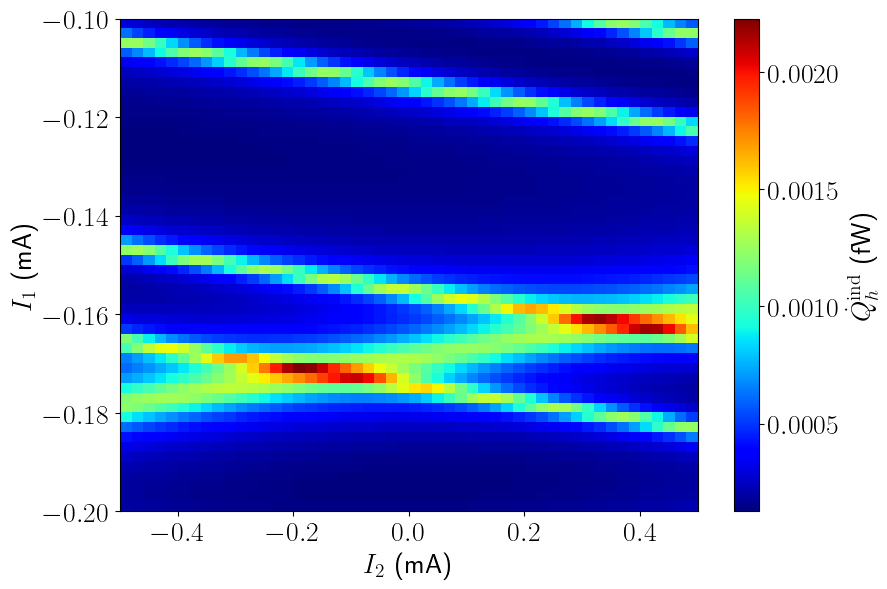

In [4]:
# Independent Heat Current for a Current Sweep with experimentally verified parameters and mutual inductance
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*Q_ind.T, 
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q^{\rm ind}_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

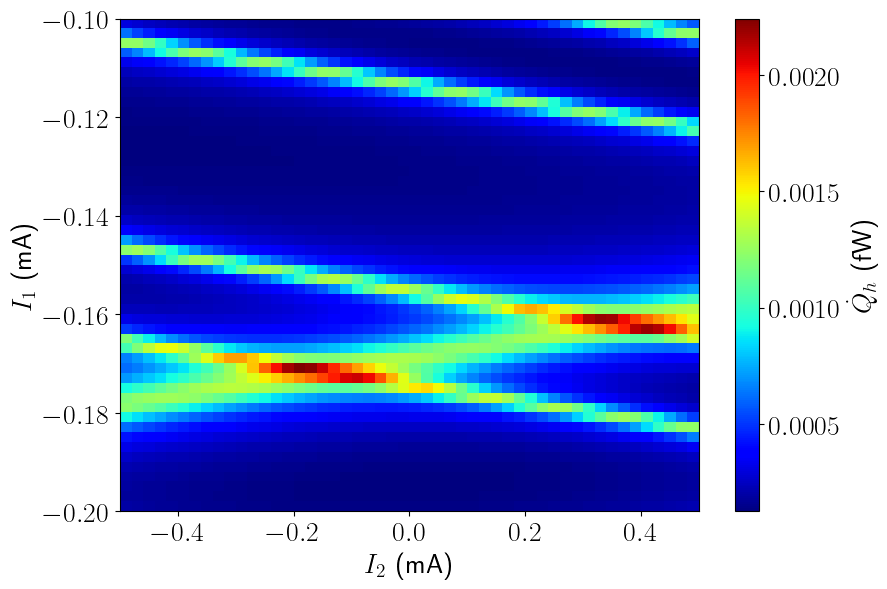

In [5]:
# Collective Heat Current for a Current Sweep with experimentally verified parameters and mutual inductance
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*Q_coll.T,  # negative heat current for display
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

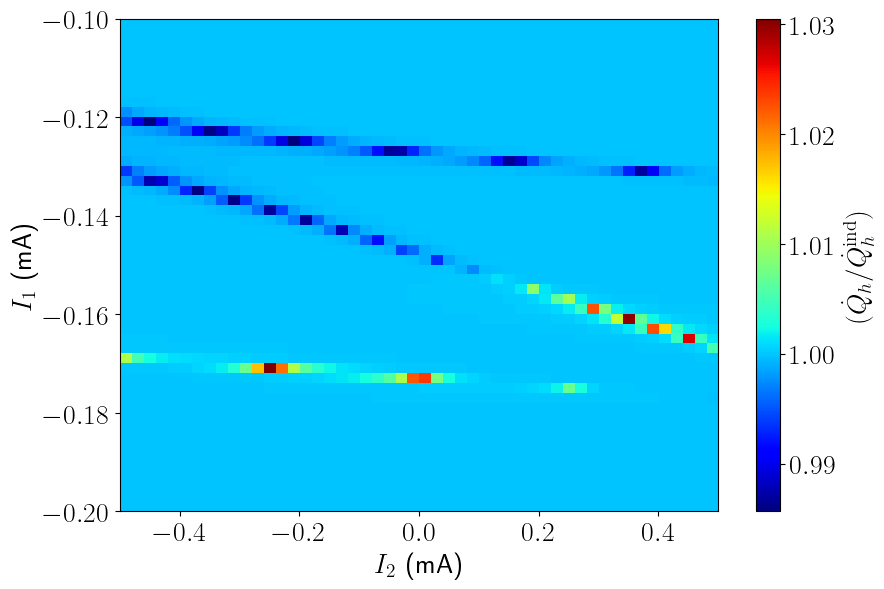

In [6]:
# Ratio between independent and collective heat current for a current sweep

plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Ratio.T,  
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$(\dot Q_h/\dot Q_h^{\rm ind})$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

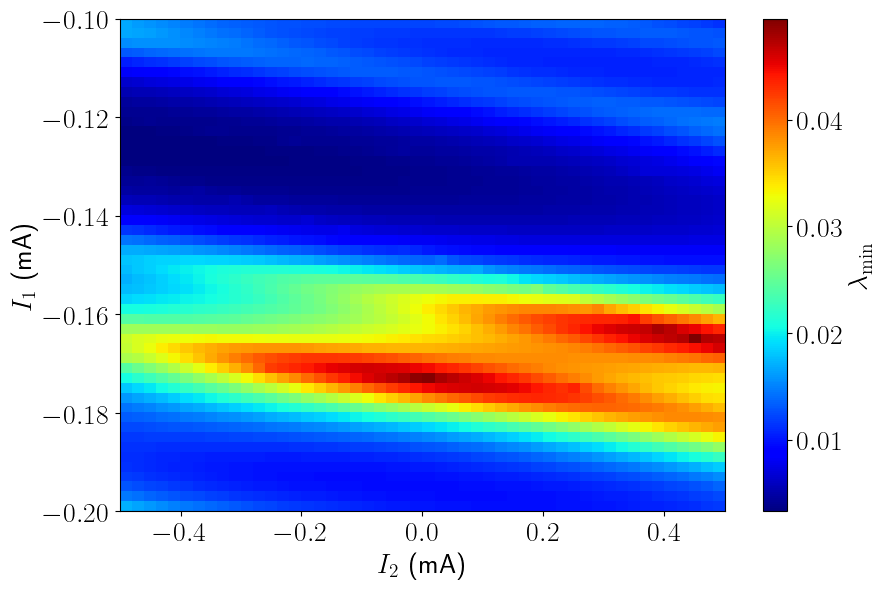

In [7]:
# Minimum eigenvalue of the collective density matrix

plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Lambda.T,  # negative heat current for display
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\lambda_{\rm min}$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

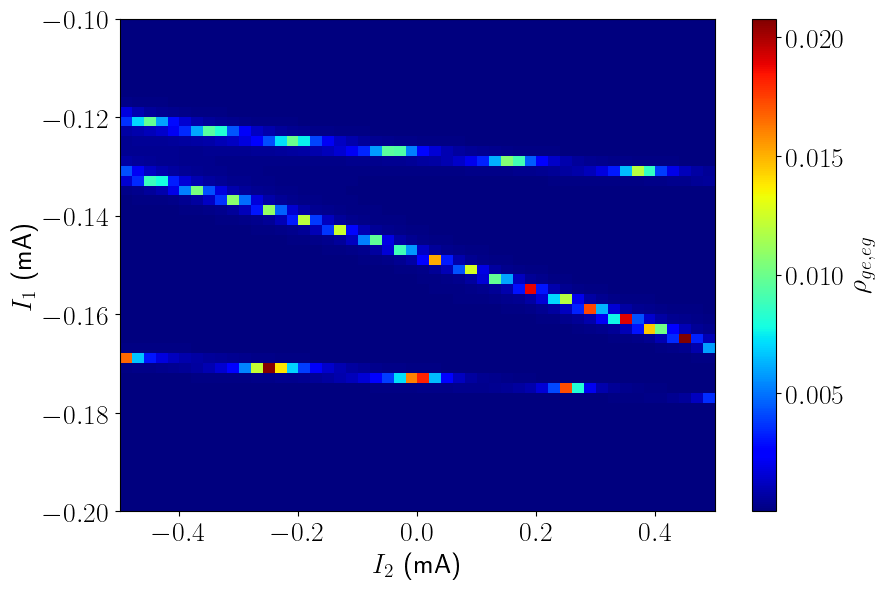

In [8]:
# Plotting one of the coherence terms in the density matrix
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Rho_coll.T,  
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\rho_{ge, eg}$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()